# Présentation du modèle de l'équipe MIA

## Résumé

Nous avons choisit de modéliser le modèle sous jacent au signaux par un système LTI. 
Nous ne disposons pas d'une solution explicite de la réponse du système en fontion de l'entrée pour des ordres et des coefficients quelconques. Ainsi, nous utilisons le module $ \it{Scipy} $ pour obtenir une solution approchée. 
Il ne reste plus qu'a choisir un ordre et optimiser les coefficients afin de minimiser l'équart entre la courbe prédite et celle données en exemple. 

## Les systèmes LTI

Un système linéaire et invariant dans le temps (LTI) à une entrée et une sortie peut être décrit mathématiquement par une équation différentielle à coefficient constant liant l'entrée du système et sa sortie. Ainsi, 

$$a_N\frac{d^N y(t)}{dt^N}+\cdots+a_1\frac{d y(t)}{dt}+a_0y(t)=b_N\frac{d^N x(t)}{dt^N}+\cdots+b_1\frac{d x(t)}{dt}+b_0 x(t)$$

où $x(t)$ désigne l'entrée du système et $y(t)$ sa sortie et $N$ correspond à l'ordre du système. Pour analyser ces systèmes, une technique couramment utilisée consiste à passer dans le domaine de Laplace. Notons $X(p)=\mathcal{L}[x(t)]$ et $Y(p)=\mathcal{L}[y(t)]$ les transformées de Laplace de l'entrée et de la sortie. En utilisant le fait que la transformée de Laplace est linéaire et que $\mathcal{L}[\frac{d^k e(t)}{dt^k}]=p^k E(p)$, il est possible de décrire la système par la fonction suivante

$$H(p)\triangleq \frac{Y(p)}{X(p)}=\frac{b_N s^N+b_{N-1}p^{N-1}+\cdots+b_1 p+b_0}{a_N p^N+a_{N-1}p^{N-1}+\cdots+a_1 p+a_0}$$

Cette fonction est appelée **fonction de transfert** du système. D'un point de vue mathématique, à l'exception des systèmes possédant un ordre faible, il est souvent plus pratique d'analyser un système dans le domaine de Laplace plutôt que dans le domaine temporel.

Le langage Python permet de créer des fonctions de transfert via la classe `lti` du module `signal` de Scipy. Cette classe prend deux tableaux en entrée: un tableau contenant les coefficients du numérateur et un tableau contenant les coefficients du dénominateur. 

# Le Modèle en action 

### Initialisation

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares, minimize

import time
from tqdm import notebook
import importlib

from sklearn.metrics import mean_absolute_error

from numpy import linalg as la

import sys
from importlib import reload,import_module
import os

import sagemaker
import boto3

%matplotlib inline

import copy

from sources.utilities.utility_functions import *

In [2]:
model_definition = "model_LTI"

MyModel = import_module('sources.utilities.' + model_definition).MyModel

### Entrainement du modèle sur un petit ensemble, sans AWS

On met en forme les données, le modèle prend en entrée un dictionnaire comme construit ci-dessous pour s'entrainer. Nous avons par conséquent, un peu modifier la fonction init de test_submission pour que le format de dictionnaire soit 

In [72]:
rep_data = "./data/DataSet_phase1/"
names_train = ["input"+str(k) for k in [0,1,2,3,4,5,6]]   ##On utilise tous les signaux pour l'entrainement

dic_train = {}
for name in names_train:
    dic_train[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

columns_titles = ['Time','Output1','Input','Output2','Output3','Output4','Output5']

for name in names_train:
    dic_train[name].columns = columns_titles
    dic_train[name] = dic_train[name][['Time','Input','Output1','Output2','Output3','Output4','Output5']]

In [73]:
retrain = True

outputs_names = ['Output1','Output2','Output3','Output4','Output5']

if retrain:
    model = MyModel.create_model(epochs_1 = 80, epochs_2 = 15, degre = 2, nbOutputs = len(outputs_names))

    model.fit(dic_train,verbose=True)   ##On travaille avec les données sous le format d'un dictionnaire
    
    retrain = False

--- Fit started ---
Calcul des 35 liste(s) de coefficients des systèmes linéaires, itérations maximales de chacune des minimisations : 80
`xtol` termination condition is satisfied.
Function evaluations 46, initial cost 4.8785e+02, final cost 3.6052e-02, first-order optimality 8.29e-06.
Avancement calcul des fonctions de transfert : 3%
`ftol` termination condition is satisfied.
Function evaluations 46, initial cost 2.4289e+02, final cost 4.5790e-02, first-order optimality 6.50e-07.
Avancement calcul des fonctions de transfert : 6%
`ftol` termination condition is satisfied.
Function evaluations 37, initial cost 2.4278e+02, final cost 3.8463e-02, first-order optimality 6.38e-07.
Avancement calcul des fonctions de transfert : 9%
`xtol` termination condition is satisfied.
Function evaluations 45, initial cost 5.9755e+02, final cost 2.5842e-01, first-order optimality 1.03e-05.
Avancement calcul des fonctions de transfert : 11%
`ftol` termination condition is satisfied.
Function evaluations 4

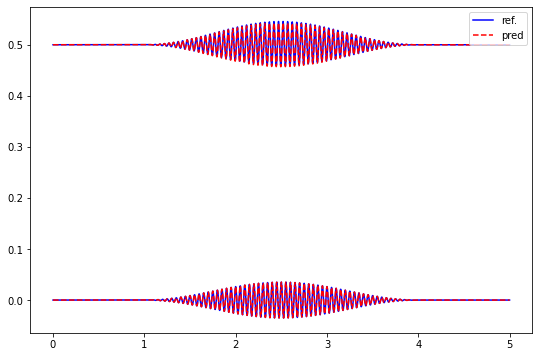

In [74]:
input_train = 'input5'

output_pred_train = model.predict_timeseries(np.array(dic_train[input_train]['Input']))
outputs_indexes = [0,1]
outputs_names = ['Output1','Output2','Output3','Output4','Output5']

fig,ax = plt.subplots(1,1,figsize=(9,6))
for k in range(len(outputs_indexes)):
    plt.plot(dic_train[input_train]['Time'],dic_train[input_train][outputs_names[k]],'b') 
    plt.plot(dic_train[input_train]['Time'],output_pred_train[:,outputs_indexes[k]],'--r')
    plt.grid()
    plt.legend(["ref.","pred"])

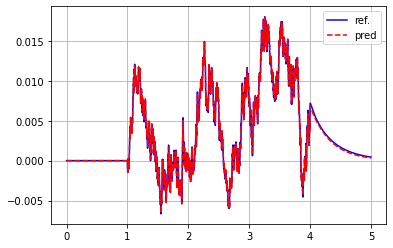

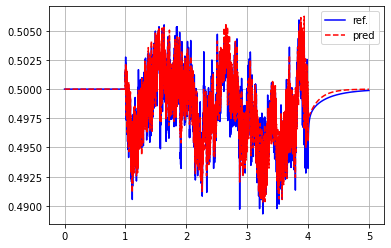

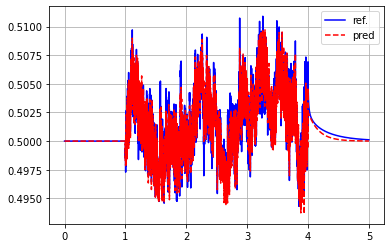

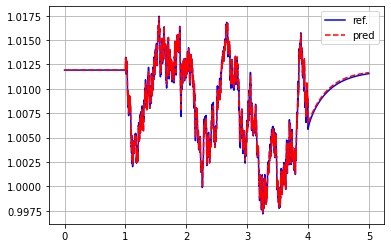

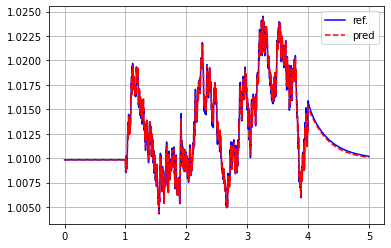

In [75]:
file_test  = "input6.csv"   ##Modifier ici avec de nouveaux inputs qui ne sont pas dans l'échantillon d'entrainement
t_test,x_test,y_test = load_data_csv(rep_data+file_test)

y_pred = model.predict_timeseries(x_test)

outputs_indexes = [0,1,2,3,4]    
for k in range(len(outputs_indexes)):
    plt.figure()
    plt.plot(t_test,y_test[:,outputs_indexes[k]],'b')
    plt.plot(t_test,y_pred[:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])        

### Tests unitaires

Le modèle prend en entrée un dictionnaire comme construit ci-dessous pour s'entrainer. Nous avons par conséquent, un peu modifier la fonction init de test_submission.

In [ ]:
if sys.platform == "win32":
    #!python sources/utilities/test_submission.py my_model1
    !python sources/utilities/test_submission_v2.py model_LTI_v2
else:
    #!python3 sources/utilities/test_submission.py my_model1
    !python3 sources/utilities/test_submission_v2.py model_LTI_v2

In [49]:
if sys.platform == 'linux':
    !pygmentize "./sources/utilities/model_LTI_v2.py"